# TP Eléments finis
## 2ème partie : Etude d'une plaque trouée en traction

### Import des libraries

In [80]:
from fedoo import * #Import all the fedoo library
import numpy as np 
import time

### Paramètres
Bien vérifier la cohérence des unités et modifier si besoin.

In [81]:
# paramètres géométriques et matériaux. Attention, il faut bien vérifier la cohérence des unités.
L = 50 #Demi-longueur de la plaque
b = 1 #Epaisseur de la plaque
h = 50 #Demi-hauteur de la plaque
R = 10 #Rayon du trou
E = 2e5 #Module d'Young
nu = 0.3 #Coefficient de Poisson
F = 10000 #Force appliquée

#paramètres du maillage : 
type_el = 'quad4' #Type d'élément (à choisir entre 'tri3', 'tri6', 'quad4', 'quad8' et 'quad9')
Nx = 11 #Nombre de noeuds sur l'axe de symétrie en bas du maillage
Ny = 11 #Nombre de noeuds sur le bord chargé à droite du maillage

### Dimension de l'espace des solutions (1D, 2D ou 3D)

Dans cette partie nous allons uniquement considérer un modèle plan (2D). Dans FEDOO, c'est à cette étape que l'on choisit entre un modèle 2D plan en contraintes planes où 2D plan en déformations planes.
Ici, un modèle en contraintes planes est considéré ("2Dstress"). 

In [82]:
Util.ProblemDimension("2Dstress") #2D with plane stress assumption
#Util.ProblemDimension("2Dplane") #2D with plane strain assumption


Dimension of the problem is now set on 2Dstress


### Géométrie/Maillage
Un maillage "structuré" est généré à partir du nombre de noeuds définis sur les bords

<IPython.core.display.Javascript object>


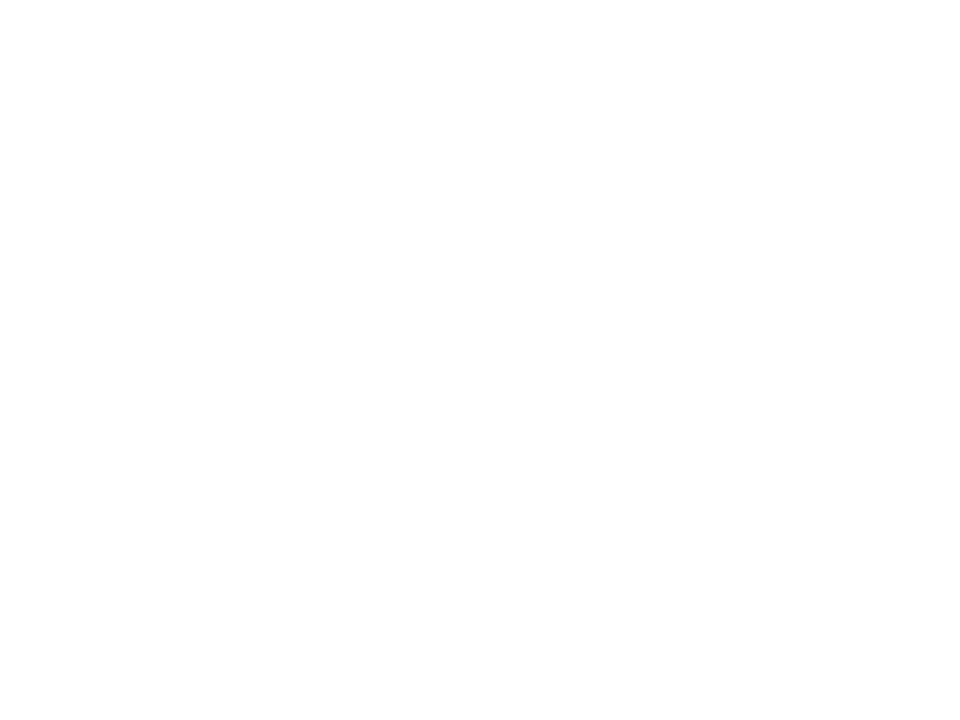

In [83]:
#list of required nodes
mesh = Mesh.Mesh(np.array([[R,0],[L,0],[L,h],[0,h],[0,R],[R*np.cos(np.pi/4),R*np.sin(np.pi/4)]]))
#generate edges
Edge1 = Mesh.GenerateNodes(mesh,Nx,(0,1)) #straight edge
Edge2 = Mesh.GenerateNodes(mesh,Ny,(1,2)) #straight edge
Edge3 = Mesh.GenerateNodes(mesh,Nx,(2,5)) #straight edge
Edge4 = Mesh.GenerateNodes(mesh,Ny,(5,0,(0,0)), typeGen = 'circular')  #curved edge
Edge5 = Mesh.GenerateNodes(mesh,Nx,(4,3)) #straight edge
Edge6 = Mesh.GenerateNodes(mesh,Ny,(3,2)) #straight edge
Edge7 = Mesh.GenerateNodes(mesh,Ny,(5,4,(0,0)), typeGen = 'circular')  #curved edge
#build structured mesh from the edge in 2 parts
mesh = Mesh.GridStructuredMesh2D(mesh, Edge1, Edge2, Edge3, Edge4, ElementShape = type_el)
mesh = Mesh.GridStructuredMesh2D(mesh, Edge5, Edge6, Edge3, Edge7, ElementShape = type_el, ID="Domain")

%matplotlib notebook
Util.meshPlot2d("Domain")

### Définition de la loi de comportement
Nous utilisons une loi de comportement Elastique, Linéaire, Homogène et Isotrope, que nous associons à une équation "InternalForce" (équation d'équilibre mécanique). Cela permet de définir le problème de minimisation de l'énergie potentielle, comme vu en cours.

In [84]:
ConstitutiveLaw.ElasticIsotrop(E, nu, ID = 'ElasticLaw')
WeakForm.InternalForce("ElasticLaw")

### Assemblage de la matice de rigidité globale

In [85]:
Assembly.Create("ElasticLaw", "Domain", type_el, ID="Assemblage", MeshChange=True) 
M = Assembly.GetAll()['Assemblage'].GetMatrix()
#print(M.todense())

### Définition du problème, conditions aux limites
A partir de l'assemblage, un problème statique linéaire est défini à partir du système :
$$ K u = F $$
où $K$ est la matrice de rigidité calculée lors de l'assemblage et $F$ est le vecteur des efforts exterieurs définit à partir des conditions aux limites en effort. Ce système doit également inclure les conditions aux limites en déplacement comme vu en cours. En l'absence de conditions aux limites en déplacement, le problème possède une infinité de solutions (mouvements de corps rigide). 

In [86]:
Problem.Static("Assemblage")

<fedoo.libProblem.Problem_Static.Static.<locals>.__Static at 0x1f43f96e048>

Pour inclure les conditions aux limites, il faut définir des listes de noeuds.
Ainsi, nous définissons les listes pour :
- le côté gauche (left) 
- le côté droit (right)
- le côté en bas (bottom)
- le côté en haut (top)
- le noeud au centre du bord droit (center)

Pour cela, la fonction numpy np.where est utilisée pour trouver des noeuds à partir de leur coordonnées. 

In [87]:
#Definition of the set of nodes for boundary conditions
crd = mesh.GetNodeCoordinates() 
xmax = np.max(crd[:,0]) ; xmin = np.min(crd[:,0])
ymax = np.max(crd[:,1]) ; ymin = np.min(crd[:,1])
left = np.where(crd[:,0] == xmin)[0]
right = np.where(crd[:,0] == xmax)[0]
top = np.where(crd[:,1] == ymax)[0]
bottom = np.where(crd[:,1] == ymin)[0]
center = right[np.abs(crd[right,1] - h/2).argmin()] #node at the center of right edge

Nous utilisons la méthode BoundaryCondition pour appliquer les conditions aux limites. 
La syntaxe est : Problem.BoudaryCondition(type_CL, composante, valeur, list_noeuds) 
- Il est possible d'appliquer des conditions aux limites en déplacement (type_CL = 'Dirichlet') ou en effort (type_CL = 'Neumann').
- composante correspond à 'DispX' ou 'DispY' pour le déplacement/force suivant x ou y.
- valeur est la valeur du déplacement ou de la force (peut prendre une liste de valeur)
- list_noeuds est la liste des noeuds sur lesquels la condition est appliquée.

Il est important d'utiliser la méthode 'ApplyBoundaryCondition()' pour les inclure/actualiser les conditions aux limites. 

In [88]:
Problem.BoundaryCondition.RemoveAll() #in case there is already some boundary conditions defined
Problem.BoundaryCondition('Dirichlet','DispX', 0,bottom)
Problem.BoundaryCondition('Dirichlet','DispY', 0,bottom)
Problem.BoundaryCondition('Dirichlet','DispX', 0,left)
Problem.BoundaryCondition('Dirichlet','DispY', 0,left)
Problem.BoundaryCondition('Neumann','DispX',F/(Ny*b), right)
Problem.ApplyBoundaryCondition()

### Résolution
Le système est résolu, soit avec une méthode directe (pivot de gauss) soit avec une méthode iterative (gradient conjugué.

In [89]:
t0 = time.time() 
#Problem.SetSolver('cg') #conjugate gradient method 
print('Solving...')
Problem.Solve() 
print('Done in ' +str(time.time()-t0) + ' seconds')

Solving...
Done in 0.0045354366302490234 seconds


### Affichage des résultats
Pour afficher les résultats, la fonction fieldPlot2d est utilisée. 
Elle permet d'afficher les contraintes (dataID='stress'), les déformations (dataID='strain') et les déplacements (dataID='disp').

Plusieurs composantes peuvent être affichées : component = 0 pour xx, 1 pour yy, 5 pour xy et 'VM' pour Von-Mises (uniquement disponible pour les contraintes).

Le déplacement max suivant X est :  0.06189992573874418
La contraintes maximale de Von-Mises est :  505.81405304368883


<IPython.core.display.Javascript object>


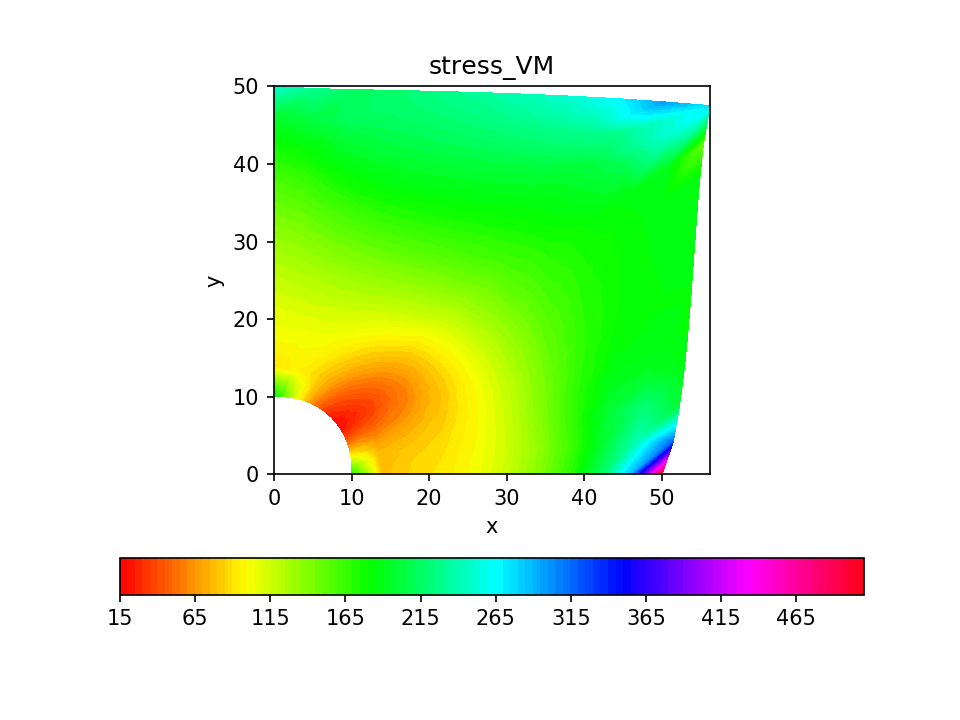

In [90]:
#Get the stress tensor (nodal values)
TensorStrain = Assembly.GetAll()['Assemblage'].GetStrainTensor(Problem.GetDisp(), "Nodal")       
TensorStress = ConstitutiveLaw.GetAll()['ElasticLaw'].GetStress(TensorStrain)

print("Le déplacement max suivant X est : ", Problem.GetDisp('DispX').max())
print("La contraintes maximale de Von-Mises est : ", TensorStress.vonMises().max())

%matplotlib notebook
Util.fieldPlot2d("Domain", "ElasticLaw", Problem.GetDisp(), dataID = 'stress', component='VM', data_min = None, data_max = None, scale_factor = 100, plot_edge = False, nb_level = 100, type_plot = "smooth")
